[*********************100%%**********************]  5 of 5 completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Final Portfolio Value: $199036.53
Total Return: 99.04%


<ipython-input-33-b9d841d87b87>:100: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12,6))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

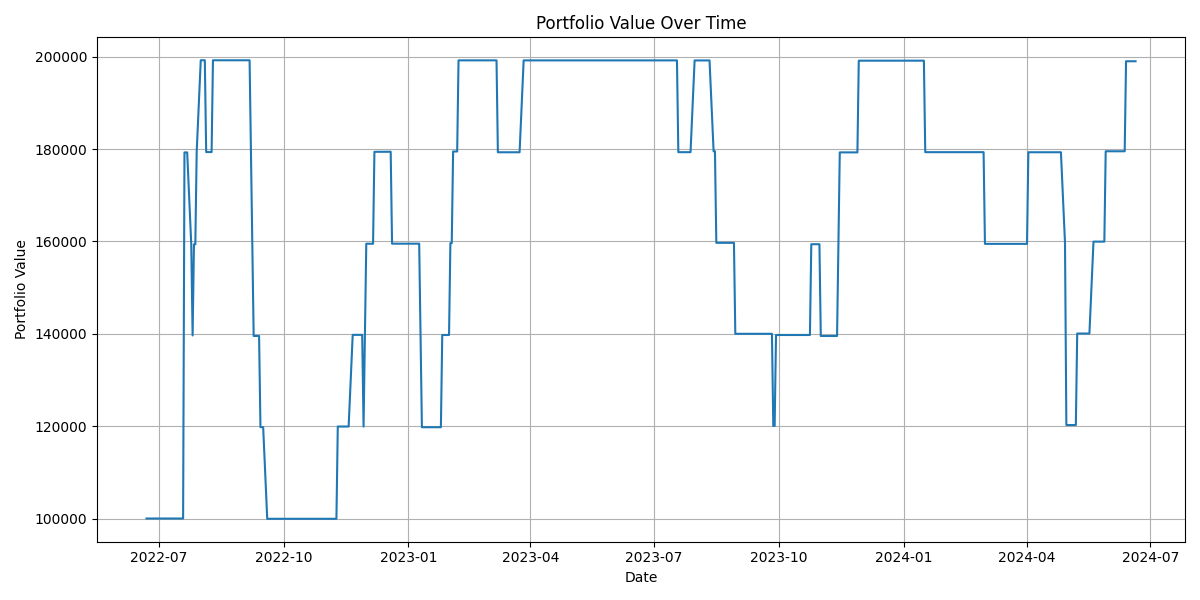

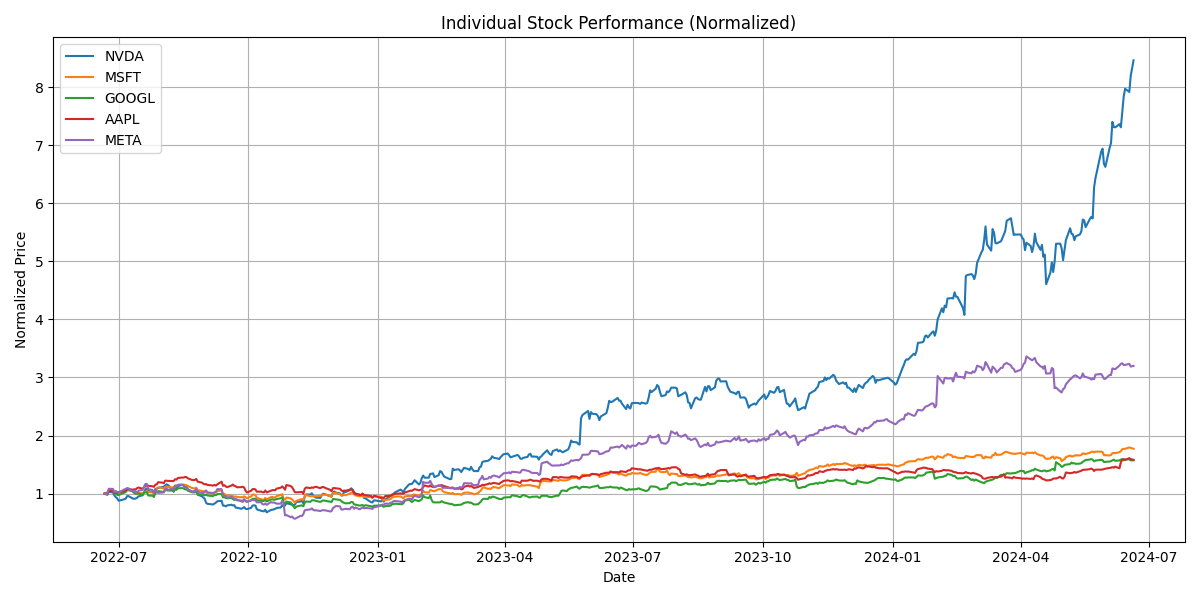

In [33]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from google.colab import files
import io
from IPython.display import Image, display

# Step 1: Define the strategy (Moving Average Crossover)
def moving_average_crossover(data, short_window, long_window):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0

    # Create short simple moving average
    signals['short_mavg'] = data.rolling(window=short_window, min_periods=1, center=False).mean()

    # Create long simple moving average
    signals['long_mavg'] = data.rolling(window=long_window, min_periods=1, center=False).mean()

    # Create signals
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:]
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()

    return signals

# Step 2: Gather and preprocess data
def get_data(symbols, start_date, end_date):
    data = yf.download(symbols, start=start_date, end=end_date)
    return data['Adj Close']

# Step 3 & 4: Implement the trading algorithm and backtest
def backtest(data, short_window, long_window, initial_capital):
    portfolio = pd.DataFrame(index=data.index).fillna(0.0)
    portfolio['total'] = initial_capital

    for symbol in data.columns:
        signals = moving_average_crossover(data[symbol], short_window, long_window)

        # Allocate equal weight to each stock
        allocation = initial_capital / len(data.columns)

        # Calculate positions and cash for each stock
        stock_positions = signals['signal'] * allocation / data[symbol]
        stock_holdings = stock_positions * data[symbol]
        cash = allocation - (signals['signal'].diff() * data[symbol]).cumsum()

        portfolio[f'{symbol}_holdings'] = stock_holdings
        portfolio[f'{symbol}_cash'] = cash

    # Sum up total portfolio value
    for symbol in data.columns:
        portfolio['total'] += portfolio[f'{symbol}_holdings'] + portfolio[f'{symbol}_cash'] - initial_capital/len(data.columns)

    portfolio['returns'] = portfolio['total'].pct_change()

    return portfolio

# Main execution
symbols = ["NVDA", "MSFT", "GOOGL", "AAPL", "META"]
end_date = datetime.now()
start_date = end_date - timedelta(days=365*2)  # Last 2 years
initial_capital = 100000

# Get data
data = get_data(symbols, start_date, end_date)

# Set moving average windows
short_window = 20
long_window = 50

# Run backtest
portfolio = backtest(data, short_window, long_window, initial_capital)

# Plot results and save as file
plt.figure(figsize=(12,6))
plt.plot(portfolio['total'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)

# Save plot as PNG
img_buf = io.BytesIO()
plt.savefig(img_buf, format='png')
img_buf.seek(0)
files.download('portfolio_value.png')  # This will prompt a download

# Print final portfolio value and total return
final_value = portfolio['total'].iloc[-1]
total_return = (final_value - initial_capital) / initial_capital * 100

print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Return: {total_return:.2f}%")

# Plot individual stock performance and save as file
plt.figure(figsize=(12,6))
for symbol in symbols:
    plt.plot(data[symbol] / data[symbol].iloc[0], label=symbol)
plt.title('Individual Stock Performance (Normalized)')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)

# Save plot as PNG
img_buf = io.BytesIO()
plt.savefig(img_buf, format='png')
img_buf.seek(0)
files.download('stock_performance.png')  # This will prompt another download

# Display images in the notebook
display(Image('portfolio_value.png'))
display(Image('stock_performance.png'))